In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
import datetime
import scipy.stats
import dataframe_image as dfi
from IPython.display import clear_output

# Genetic Algorithm function

In [2]:
def fitness(population, func_op):
    popsize = np.shape(population)[0]
    dim = np.shape(population[0])[0]
    x = population
    # problem에 따라 계산을 달리하기 위해 operator 값 지정
    # rosenbrock, rastrigin, griewank은 행을 따라 값을 계산(axis=1)
    if func_op == 0: # rosenbrock
        x1 = x[:, :-1]
        x2 = x[:, 1:]
        fitness = np.sum(100 * (x2 - x1**2)**2 + (1 - x1)**2, axis=1)

    if func_op == 1: # rastrigin
        fitness = 10 * dim + np.sum(x**2 - 10 * np.cos(2 * np.pi * x), axis=1)

    if func_op == 2: # griewank
        i = np.arange(1, dim+1)
        fitness = 1 + np.sum(x**2/4000, axis=1) - np.prod(np.cos(x/np.sqrt(i)), axis=1)
    
    if func_op == 3: # SIX-HUMP CAMEL FUNCTION
        x1 = x[:, 0]
        x2 = x[:, 1]
        fitness = (4 - 2.1 * x1**2 + x1**4 / 3) * x1**2 + x1 * x2 + (-4 + 4 * x2**2) * x2**2

    return fitness # 계산된 fitness는 배열의 형태로 저장되어 반환

def evaluate(fit): # 평가 함수
    scaling = fit + np.abs(np.min(fit)) # negative value 제거

    return 1 / (1 + scaling) # minimize를 위해 분수로 변환, divide 0 문제를 해결하기 위해 1을 더함

def sus_select(population, fit): # stochastic universal sampling
    N = 2 # 선택할 부모의 수
    dim = np.shape(population[0])[0]
    mating_pool = np.full((2, dim), np.nan) # 부모가 될 individuals를 저장할 배열 생성
    sorted_idx = np.argsort(-fit) # 큰 fitness를 가진 index 순으로 정렬하여 index 반환, 정렬을 통해 어느 정도 높은 fitness를 가진 individual이 선택되도록 보장, 필수 요소는 아님
    sorted_population = population[sorted_idx] # 정렬된 index를 가지고 population에서 individual 추출하여 정렬된 population 구성
    sorted_fit = fit[sorted_idx] # 정렬된 population에 대응되도록 fitness 순서도 함께 정렬
    p = sorted_fit / np.sum(sorted_fit) # 전체 fitness에서 각 individuals들이 차지하는 비율 계산

    cumfit = np.cumsum(p) # 비율의 누적합 배열 생성, roulette에 해당
    cumfit[-1] = 1.0 # 마지막 값이 0.999.... 로 계산되므로 혹시 모를 문제를 방지하기 위해 마지막 값을 1.0로 변경
    
    r = np.random.uniform(0, 1 / N) # roulette의 시작 위치 지정, 1쌍의 부모를 선택하므로 위치는 roulette의 반을 넘지 않는다.
    ptr = np.zeros(N) # 부모를 선택할 포인터
    for i in range(N):
        ptr[i] = r + i * (1 / N) # 시작 위치와 시작 위치의 절반만큼 이동한 위치가 부모를 선택하는 포인터의 위치가 된다. 위치는 대칭을 이룬다.
    i = 0 # roulette 탐색 위치 설정
    
    for marker, p in enumerate(ptr):
        while cumfit[i] < p: # roulette을 한 칸씩 이동하면서 포인터가 위치한 곳을 탐색
            i += 1
        mating_pool[marker] = sorted_population[i] # 포인터를 찾으면 해당 위치에 해당하는 individual을 저장

    return mating_pool[0], mating_pool[1]

def bts_select(population, fit): # binary tournament selection
    k = 2 # tournament size, binary tournament이므로 2로 고정
    popsize = np.shape(population)[0]
    dim = np.shape(population[0])[0]
    mating_pool = np.full((2, dim), np.nan) # 부모가 될 individuals를 저장할 배열 생성

    for i in range(2): # 선택할 individuals의 수만큼 반복 
        indiv_idx = [np.random.choice(range(0, popsize)) for _ in range(k)] # tournament size개의 individuals의 indedx를 무작위로 선택
        selected_indiv = population[indiv_idx] # 선택된 index에 해당하는 individuals 저장
        selected_fit = fit[indiv_idx] # 선택된 individuals의 fitness 저장
        sorted_idx = np.argsort(-selected_fit) # 선택된 individuals의 fitness 비교를 정렬로 대신하며, 우승한 individual의 index 저장
        
        mating_pool[i] = selected_indiv[sorted_idx[0]]
        # 우승한 individual를 선택, 우승자의 위치에 따라 sorted_idx[0]의 값은 0 또는 1

    return mating_pool[0], mating_pool[1]

def crossover(individuals, lower, upper, pc, n): # simulated binary crossover
    parents = copy.deepcopy(individuals) # 2개의 individuals를 저장
    popsize = np.shape(parents)[0]
    dim = np.shape(parents[0])[0]
    crossover_pool = np.full((popsize, dim), np.nan) # 생성된 offspring을 저장할 배열 생성
    pow = 1 / (n + 1)
    
    c_probability = np.random.uniform(0, 1) # 함수가 호출될 때마다 crossover rate 생성
    if c_probability <= pc: # crossover rate에 따라 crossover 수행
        for i, (p1, p2) in enumerate(zip(parents[0], parents[1])): #parents의 각 gene을 p1, p2로 대응, i는 gene의 index
            u = np.random.uniform()
            if u <= 0.5:
                beta = np.power(2 * u, pow)
            else:
                beta = np.power(1 / (2 * (1 - u)), pow)
                
            # problem에 bound가 정해져 있어서 bound를 유지할 수 있도록 코드 작성
            crossover_pool[0][i] = min(max(0.5 * ((p1 + p2) + beta * (p1 - p2)), lower), upper)
            crossover_pool[1][i] = min(max(0.5 * ((p1 + p2) + beta * (p2 - p1)), lower), upper)
            
    else: # crossover가 발생하지 않았을 경우, 부모 그대로 유전
        crossover_pool[0] = parents[0]
        crossover_pool[1] = parents[1]

    return crossover_pool


def mutate(individuals, lower, upper, pm, n): # polynomial mutation
    x = copy.deepcopy(individuals) # 코드 작성에 용이하도록 crossover의 결과물을 별도의 변수로 저장
    popsize = np.shape(individuals)[0]
    dim = np.shape(individuals[0])[0]
    mutate_pool = np.full((popsize, dim), np.nan) # 생성된 mutante를 저장할 배열 생성
    pow = 1 / (n + 1)

    for i in range(popsize):
        for j in range(dim): # 모든 gene에 대해 수행
            m_probability = np.random.uniform(0, 1) # 함수가 호출될 때마다 mutation rate 생성
            if m_probability <= pm: # mutation rate에 따라 mutate 수행, mutation이 발생하지 않으면 원래 gene 유지
                u = np.random.uniform(0, 1)
                if u < 0.5: # problem에 bound가 정해져 있어서 bound를 유지할 수 있도록 코드 작성
                    xi = np.power(2 * u, pow) - 1
                    x[i][j] = min(max(x[i][j] + xi * (x[i][j] - lower), lower), upper)
                else:
                    xi = 1 - np.power(2 * (1 - u), pow)
                    x[i][j] = min(max(x[i][j] + xi * (upper - x[i][j]), lower), upper)

    mutate_pool[0] = x[0]
    mutate_pool[1] = x[1]

    return mutate_pool


def find_similar(c, d):
    similarity = np.sum(np.power(c - d, 2)) # 유사한 individuals을 찾기 위해 euclidean distance 사용
    return np.sqrt(similarity)

def rts_select(population, mutant, w, op): # restricted tournament selection
    new_population = copy.deepcopy(population) # steady-state 형태이므로 기존 population을 그대로 복사
    popsize = np.shape(population)[0]
    dim = np.shape(population[0])[0]

    for i in range(popsize):
        distance = math.inf # 거리 초기화
        position = 0 # 초기 탐색 위치
        mutant_eval = evaluate(fitness(mutant[i].reshape(-1, dim), op)) # mutant의 fitness를 평가
        idx = [np.random.choice(range(0, popsize)) for _ in range(w)] # population 내 individuals의 index를 window size만큼 무작위 선택
        
        comparison_set = population[idx] # 선택된 index를 가진 index에 해당하는 individuals를 mutant와 비교하기 위해 배열에 저장
        for j in range(w): # window size만큼 반복
            similarity = find_similar(mutant[i], comparison_set[j]) # mutant와 경쟁자의 유사도 계산
            if similarity < distance: #계산한 유사도가 distance보다 작을 경우
                distance = similarity # 거리를 계산한 유사도로 갱신
                competitor = comparison_set[j] # 배열에서 다음 경쟁자 선택
                position = idx[j] # 가까운 경쟁자의 원 population 내 index를 저장
        
        competitor_eval = evaluate(fitness(competitor.reshape(-1, dim), op)) # 최종 경쟁자의 fitness를 평가

        if mutant_eval > competitor_eval: # mutant가 최종 경쟁자의 평가보다 좋을 경우
            new_population[position] = mutant[i] # mutant를 원 population 내, 최종 경쟁자와 교체함
                
    return new_population

# Experiment result processing

In [3]:
def cal_res(last_pi, last_fits): # 결과 처리 함수
    MBF = np.array(last_pi).mean() # 알고리즘의 BSF의 평균 계산
    avg_fit = np.array(last_fits).mean(axis = 0) # 각 실험의 최종 fitness를 individuals에 맞춰 평균을 계산
    
    return MBF, avg_fit

In [4]:
def visualize(gen, name, metric1, metric2, labeling, y_range=None): # 결과 시각화 함수
    # gen: 진행된 세대 수
    # exp: 실행한 실험
    plt.figure(figsize=(10, 6))
    exp_label = [str(i) for i in range(1, 21, 1)] # 실험 횟수로 x축 생성
    evaluation = gen * 100 // 20

    plt.xticks(range(0, 20, 1), exp_label); plt.xlabel(f"{evaluation} X NOFE"); plt.ylabel(labeling); plt.grid(True)
    plt.plot(metric1, 'ro-', label='BTS')
    plt.plot(metric2, 'g*--', label="RTS")
    plt.legend()
    plt.savefig(name+'_'+labeling+'_'+'plot')
    plt.show()

In [30]:
pd.options.display.float_format = '{:.6f}'.format

def save_pd(metric1, metric2, name): # 결과 분석 함수
    labels = ['BTS', 'RTS']
    # 실험의 BSF의 평균, 표준편차, 최소, 최대, 사분위 값을 계산하여 저장
    pd_metric1 = pd.DataFrame(metric1, columns=[labels[0]]).describe()
    metric1_var = pd.DataFrame([[np.array(metric1).var()]], index = ['var'], columns = pd_metric1.columns)
    pd_metric1 = pd.concat([pd_metric1[:2], metric1_var, pd_metric1[2:]])
    
    pd_metric2 = pd.DataFrame(metric2, columns=[labels[1]]).describe()
    metric2_var = pd.DataFrame([[np.array(metric2).var()]], index = ['var'], columns = pd_metric2.columns)
    pd_metric2 = pd.concat([pd_metric2[:2], metric2_var, pd_metric2[2:]])
    
    dfi.export(pd_metric1, name+'_bts_acp_describe.png')
    dfi.export(pd_metric2, name+'_rts_acp_describe.png')
    print('Complete')

# Runnig algorithm

In [ ]:
# 원활한 실험을 위해, 20개의 problem을 생성하여 csv로 저장
'''
rosenbrock_problem = np.full((20, 3000), np.nan)
rastrigin_problem = np.full((20, 3000), np.nan)
griewank_problem = np.full((20, 3000), np.nan)
shc_problem = np.full((20, 200), np.nan)

for i in range(20):
    rosenbrock_problem[i] = np.random.uniform(low=-30, high=30, size = (3000))
    rastrigin_problem[i] = np.random.uniform(low=-5.12, high=5.12, size = (3000))
    griewank_problem[i] = np.random.uniform(low=-600, high=600, size = (3000))
    shc_problem[i] = np.random.uniform(low=-5, high=5, size = (200))

pd.DataFrame(rosenbrock_problem).to_csv("problems/rosenbrock_problem.csv", header=None, index=None)
pd.DataFrame(rastrigin_problem).to_csv("problems/rastrigin_problem.csv", header=None, index=None)
pd.DataFrame(griewank_problem).to_csv("problems/griewank_problem.csv", header=None, index=None)
pd.DataFrame(shc_problem).to_csv("problems/shc_problem.csv", header=None, index=None)
'''

In [6]:
# 생성한 problem을 load하여 배열에 형태로 저장
rosenbrock = np.array(pd.read_csv('problems/rosenbrock_problem.csv', header=None))
rastrigin = np.array(pd.read_csv('problems/rastrigin_problem.csv', header=None))
griewank = np.array(pd.read_csv('problems/griewank_problem.csv', header=None))
shc = np.array(pd.read_csv('problems/shc_problem.csv', header=None))

If we want only one best solution by the end of the run, BSF might be the proper selection.  
But if all the popsize individuals will be used by the end of the run, BCP, ACP, and WCP describe the performance of the algorithm from
various viewpoints.

popsize가 크므로 평균을 기준으로 성능 지표를 확인

In [7]:
class Algorithm: # 진화 알고리즘
    def __init__(self, n_run, gen, problem, selector):
        self.n_run = n_run # 진행할 실험 횟수
        self.gen = gen # 최대 세대, 종료 조건
        self.problem = problem # 적용할 문제
        self.BSF = []
        self.BCP = [] # 문제의 BCP를 저장할 배열
        self.ACP = [] # 문제의 ACP를 저장할 배열
        self.WCP = []
        self.last_ACP = []
        self.last_fits = [] # 문제의 fitness를 저장할 배열
        self.selector = selector # 알고리즘의 선택 연산
        
    def evolve(self, pc, n_c, pm, n_m, w=None): 
        dim = np.shape(self.problem[1][0])[0] // 100 # 전달받은 문제에 따라 fitness 함수와 상하한 결정
        selectors = {'SUS': sus_select(population, evaluation), 
                     'BTS': bts_select(population, evaluation), 
                     'RTS': population[[np.random.choice(range(0, popsize)) for _ in range(2)]]}
        problems = {'rosenbrock': [-30, 30, 0], 
                    'rastrigin': [-5.12, 5.12, 1], 
                    'griewank': [-600, 600, 2], 
                    'shc': [-5, 5, 3]}
        lower, upper, func_op = problems[self.problem[0]]

        for x in range(self.n_run): # 실험 횟수
            population = copy.deepcopy(self.problem[1][x]).reshape(100, dim) # 호출한 problem을 적절한 형태로 변환
            pool = np.full((np.shape(population)[0], np.shape(population[0])[0]), np.nan) # 다음 세대의 초기 population
            popsize = np.shape(population)[0]

            i = 1 # 초기 세대
            found_BSF = math.inf # 초기 BSF 값

            np.set_printoptions(precision=6, suppress=True) # 진행 과정을 확인하기 위해 출력하는 individual의 gene 자릿수 조정
            while i <= self.gen: # 최대 세대까지의 진행이 종료 조건
                fit = fitness(population, func_op) # 매 세대가 시작될 때마다 fitness 계산
                
                if fit.min() < found_BSF: # 매 세대에서 BSF 탐색, 이전 세대 BSF와 비교하여 더 좋은 BSF를 발견하면 갱신
                    found_BSF = fit.min()
                if i % (self.gen / 20) == 0 and x == 0:# 20번의 plotting, each total generation / 20 x popsize evaluation, 첫 실험에 대해서만
                    self.BSF.append(found_BSF)
                    self.BCP.append(fit.min())
                    self.ACP.append(fit.mean()) # plotting 용
                    self.WCP.append(fit.max())
                    
                evaluation = evaluate(fit) # 매 세대마다 fitness 평가
                print(f"================================run{x+1}===================================")
                print(f"================================gen{i}===================================")
                print(f"Fitness: {fit.mean(): .17f} \tEvaluation: {evaluation.mean(): .17f}")
                print("=========================================================================")
                print(population.mean(axis=0))
                # 진행 과정을 확인하기 위해 현재 fitness의 평균과 evaluation 값, 첫 번째 individual 등을 출력
                clear_output(wait=True) # jupyter 상의 출력 콘솔 정리

                for j in range(0, popsize, 2): # 2개의 individuals를 선택해 2개의 offspring을 생성하므로 이와 같은 반복문 수행
                    # 실질적인 genetic algorithm 수행부, slmple genetic algorithm을 채택
                    selection = selectors[self.selector]
                    offspring = crossover(selection, lower, upper, pc, n_c)
                    mutation = mutate(offspring, lower, upper, pm, n_m)
                    pool[j] = mutation[0]
                    pool[j+1] = mutation[1]
                if self.selector == 'RTS': 
                    pool = rts_select(population, pool, w, func_op)
                population = copy.deepcopy(pool) # 새로운 population 구성이 완료되면 population 세대 교체
                i += 1 # 다음 세대로 전환
            self.last_ACP.append(fit.mean()) # 실험이 끝날 때마다, 최종 ACP 저장, t-test 및 MBF 계산용
            self.last_fits.append(fit) # 실험이 끝날 때마다, 최종 population의 fitness 저장
        
        MBF, avg_fit = cal_res(self.last_ACP, self.last_fits)
        return self.BSF, self.BCP, self.ACP, self.WCP, MBF, avg_fit

1번의 iteration = 한 세대의 교체 = popsize만큼 평가가 이루어짐  
5000번의 세대 교체가 이뤄졌다면 평가 횟수는 5000 x popsize

In [8]:
metrics = ['Best so far', 'Best of current population', 'Average of current population', 'Worst of current population']

# 실험 2.1 Rastrigin RTS vs BTS

In [41]:
B_algorithm1 = Algorithm(20, 3000, ('rastrigin', rastrigin), 'BTS')
B_BSF1, B_BCP1, B_ACP1, B_WCP1, B_MBF1, B_avg_fits1, B_time1 = B_algorithm1.evolve(pc=1.0, n_c=10, pm=0.005, n_m=10)

================================run1===================================
================================gen10000===================================
Fitness:  0.99900064600030247 	Evaluation:  0.33405879300632479
[ 0.       -0.000005  0.000007  0.        0.000005  0.       -0.
 -0.994958 -0.000052  0.000005 -0.000021 -0.       -0.000001  0.
  0.       -0.       -0.000001 -0.000039 -0.       -0.000024  0.
  0.        0.000005  0.        0.        0.000005  0.00005   0.000018
 -0.000037  0.000011]


In [225]:
C_algorithm1 = Algorithm(20, 3000, ('rastrigin', rastrigin), 'RTS')
C_BSF1, C_BCP1, C_ACP1, C_WCP1, C_MBF1, C_avg_fits1, C_time1 = C_algorithm1.evolve(pc=1.0, n_c=2, pm=0.005, n_m=10, w = 2)

================================run20===================================
================================gen3000===================================
Fitness:  0.00000000003058346 	Evaluation:  0.99999999994758870
[ 0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0.
  0.  0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0.]


In [245]:
print(f'MBF of RTS: {C_MBF1}\nMBF of BTS: {B_MBF1}')
if C_MBF1 > B_MBF1: print(f'BTS is better than RTS')
else: print(f'RTS is better than BTS')

MBF of RTS: 1.829337670281461e-05
MBF of BTS: 1.4284237438092182
RTS is better than BTS


In [227]:
name = 'rastrigin'

gen = 3000
metric11=B_BSF1; metric12=C_BSF1;
metric13=B_BCP1; metric14=C_BCP1;
metric15=B_ACP1; metric16=C_ACP1;
metric17=B_WCP1; metric18=C_WCP1;

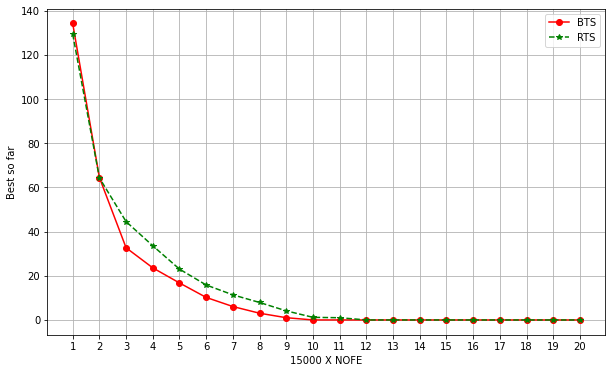

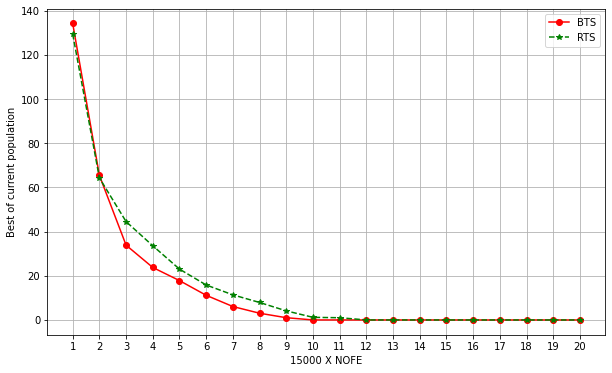

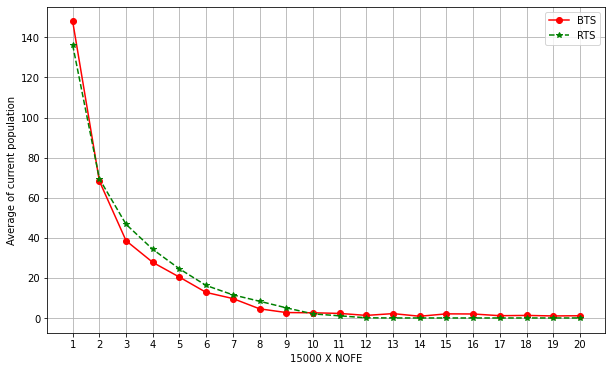

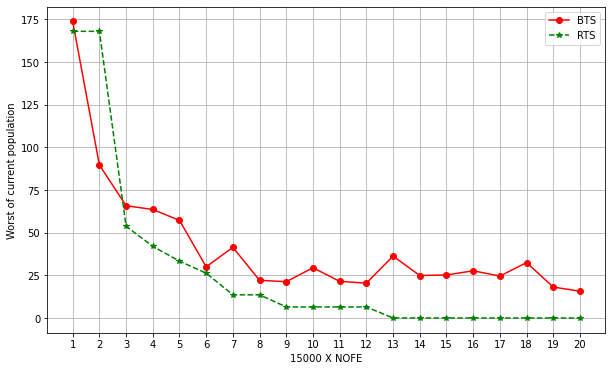

In [228]:
for i in range(len(metrics)):
    visualize(gen, name, eval('metric1'+str(i*2+1)), eval('metric1'+str(i*2+2)), metrics[i])

In [229]:
scipy.stats.ttest_ind(B_BSF1, C_BSF1)

Ttest_indResult(statistic=-0.2175470172745503, pvalue=0.8289460047616497)

In [237]:
save_pd(B_ACP1, C_ACP1, 'rastrigin') # individuals의 fitness들

Complete


# 실험 2.2 Griewank RTS vs BTS

In [9]:
B_algorithm2 = Algorithm(20, 2000, ('griewank', griewank), 'BTS')
B_BSF2, B_BCP2, B_ACP2, B_WCP2, B_MBF2, B_avg_fits2, B_time2 = B_algorithm2.evolve(pc=1.0, n_c=2, pm=0.001, n_m=10)

================================run20===================================
================================gen2000===================================
Fitness:  0.02173028415009460 	Evaluation:  0.99089218228991782
[-0.       -0.       -0.        0.       -0.        0.       -0.
  0.       -0.       -0.       -0.       -0.       -0.       -0.
 -0.       -0.        0.       -0.000001 -0.       -0.        0.
 -0.       -0.       -0.        0.        0.       -0.       -0.000001
 -0.        0.000001]


In [10]:
C_algorithm2 = Algorithm(20, 2000, ('griewank', griewank), 'RTS')
C_BSF2, C_BCP2, C_ACP2, C_WCP2, C_MBF2, C_avg_fits2, C_time2 = C_algorithm2.evolve(pc=1.0, n_c=2, pm=0.001, n_m=5, w = 2)

================================run20===================================
================================gen2000===================================
Fitness:  0.03433522608187309 	Evaluation:  0.93574216258685150
[ 3.140023 -0.        0.        0.000002 -0.000001 -0.000001  0.000001
  0.       -0.       -0.        0.000001  0.       11.254017 -0.000001
 -0.000001 -0.000001 -0.000001 -0.000001 -0.000001 -0.000001  0.
 -0.000001  0.000001 -0.000001 -0.       -0.000002  0.000002  0.000001
  0.000001  0.000002]


In [11]:
print(f'MBF of RTS: {C_MBF2}\nMBF of BTS: {B_MBF2}')
if C_MBF2 > B_MBF2: print(f'BTS is better than RTS')
else: print(f'RTS is better than BTS')

MBF of RTS: 0.017587814944918102
MBF of BTS: 0.09797605227729454
RTS is better than BTS


In [13]:
name = 'griewank'

gen=2000
metric21=B_BSF2; metric22=C_BSF2;
metric23=B_BCP2; metric24=C_BCP2;
metric25=B_ACP2; metric26=C_ACP2;
metric27=B_WCP2; metric28=C_WCP2;

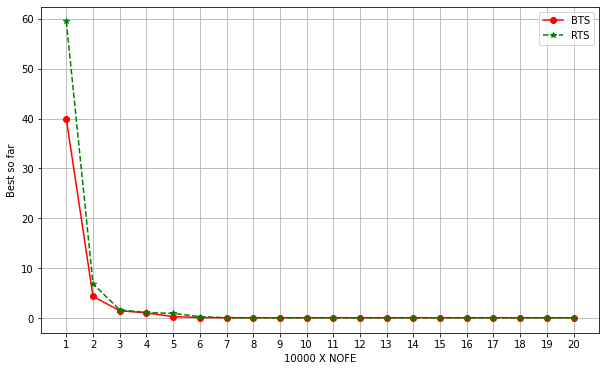

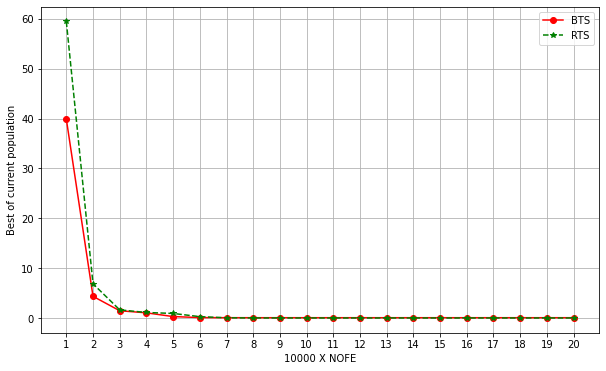

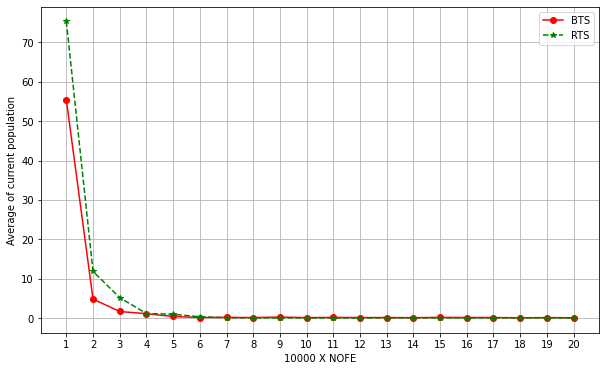

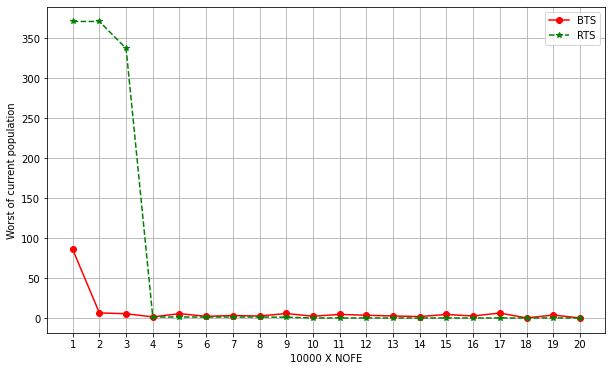

In [14]:
for i in range(len(metrics)):
    visualize(gen, name, eval('metric2'+str(i*2+1)), eval('metric2'+str(i*2+2)), metrics[i])

In [15]:
scipy.stats.ttest_ind(B_BSF2, C_BSF2)

Ttest_indResult(statistic=-0.3143263892670374, pvalue=0.7549924645630768)

In [17]:
save_pd(B_ACP2, C_ACP2, 'griewank') # individuals의 fitness들

Complete


# 실험 2.3 Six-Hump Camel RTS vs BTS

In [18]:
B_algorithm3 = Algorithm(20, 100, ('shc', shc), 'BTS')
B_BSF3, B_BCP3, B_ACP3, B_WCP3, B_MBF3, B_avg_fits3, B_time3 = B_algorithm3.evolve(pc=1.0, n_c=2, pm=0.001, n_m=10)

================================run20===================================
================================gen100===================================
Fitness: -1.03162845348987720 	Evaluation:  1.00000000000000000
[ 0.089842 -0.712656]


In [19]:
C_algorithm3 = Algorithm(20, 100, ('shc', shc), 'RTS')
C_BSF3, C_BCP3, C_ACP3, C_WCP3, C_MBF3, C_avg_fits3, C_time3 = C_algorithm3.evolve(pc=1.0, n_c=2, pm=0.001, n_m=10, w = 2)

================================run20===================================
================================gen100===================================
Fitness: -0.39419354588602040 	Evaluation:  0.64475971001071342
[0.046538 0.317614]


In [20]:
print(f'MBF of RTS: {C_MBF3}\nMBF of BTS: {B_MBF3}')
if C_MBF3 > B_MBF3: print(f'BTS is better than RTS')
else: print(f'RTS is better than BTS')

MBF of RTS: 7.783696573678922
MBF of BTS: -1.0310368578169415
BTS is better than RTS


In [22]:
name = 'six-hump camel'

gen=100
metric31=B_BSF3; metric32=C_BSF3;
metric33=B_BCP3; metric34=C_BCP3;
metric35=B_ACP3; metric36=C_ACP3;
metric37=B_WCP3; metric38=C_WCP3;

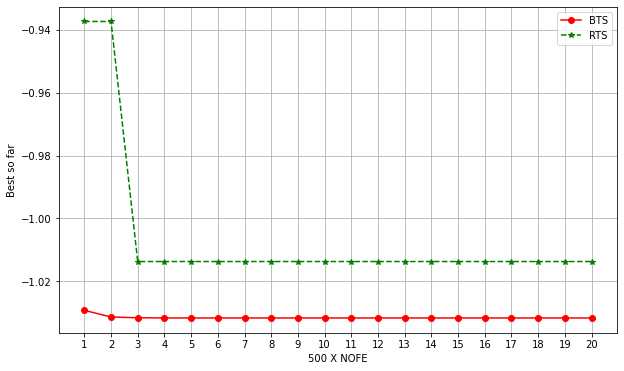

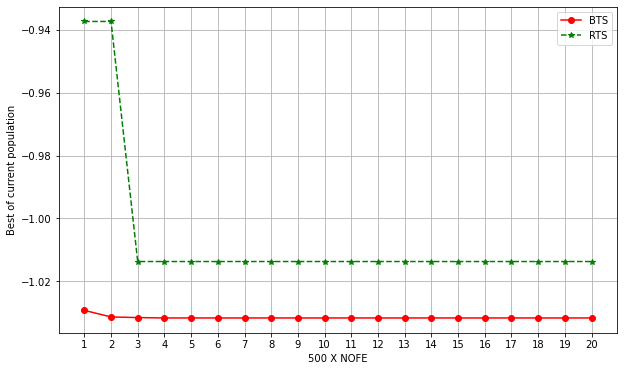

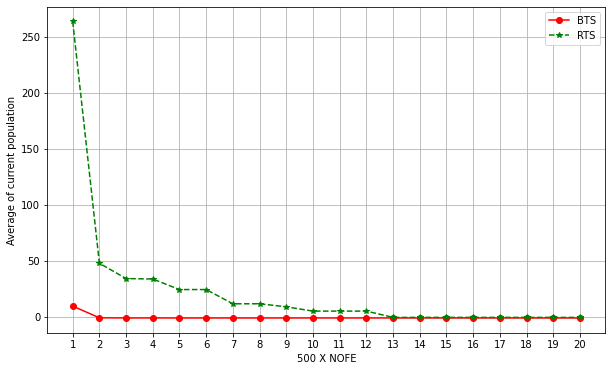

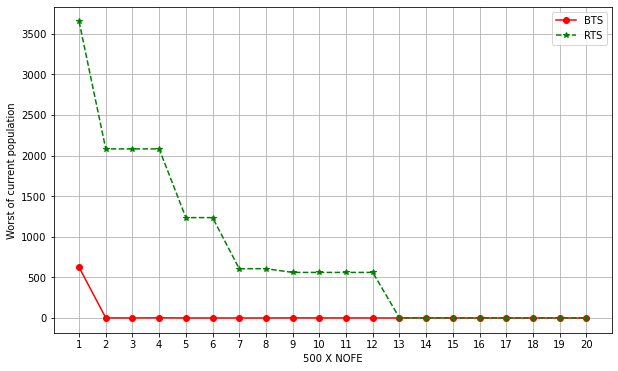

In [23]:
for i in range(len(metrics)):
    visualize(gen, name, eval('metric3'+str(i*2+1)), eval('metric3'+str(i*2+2)), metrics[i])

In [24]:
scipy.stats.ttest_ind(B_BSF3, C_BSF3)

Ttest_indResult(statistic=-4.841851915512529, pvalue=2.173188072983406e-05)

In [31]:
save_pd(B_ACP3, C_ACP3, 'shc') # individuals의 fitness들

Complete
